In [35]:
import os
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report


Shape of No Substructure: (1, 64, 64)
Shape of Cold Dark Matter (CDM): (1, 64, 64)


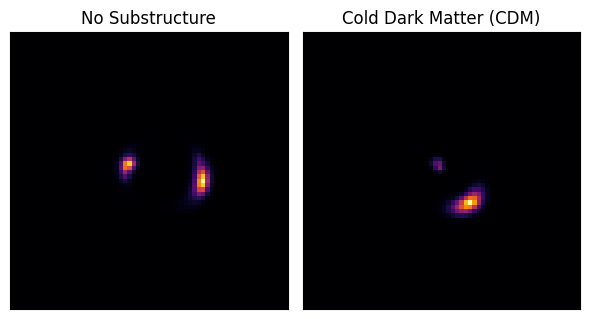

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4)) # 'axion': ncols = 3
 
for i, (folder_path, title) in enumerate([
    ('Model_IV/train/no_sub', 'No Substructure'),
    # ('Model_IV/train/axion', 'Axion'),
    ('Model_IV/train/cdm', 'Cold Dark Matter (CDM)')]):
    file_name = os.listdir(folder_path)[7]
    file_path = os.path.join(folder_path, file_name)
    loaded_file = np.load(file_path, allow_pickle=True)
    print(f'Shape of {title}: {loaded_file.shape}') # Since the dataset states that 'Axion files have extra data corresponding to mass of axion used in simulation'. So the .npy file has a shape of 2, having the image and this mass.

    # if (folder_path == 'Model_IV/train/axion'):
    #     img_array = loaded_file[0]
    # else:
    #     img_array = loaded_file
    img_array = loaded_file

    img_array = np.squeeze(img_array)  # Only for MODEL IVV to convert (1, 64, 64) to (64, 64), since Keras requires this
    axs[i].imshow(img_array, cmap='inferno')
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

In [59]:
width = 2048
num_epochs = 30
batch_size = 128
lr = 1e-4
input_shape = (64, 64, 1)

In [60]:
def random_flip_rotate_resize(image):
    # Horizontal flipping
    horizontal_flip = tf.random.uniform(shape=[])
    if horizontal_flip < 0.5:
        image = tf.image.flip_left_right(image)
    # Vertical flipping
    vertical_flip = tf.random.uniform(shape=[])
    if vertical_flip < 0.5:
        image = tf.image.flip_up_down(image)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Resizing to original size
    image = tf.image.resize(image, size=[64, 64])
    
    return image


@tf.function
def augment_image_pretraining(image):
    image = random_flip_rotate_resize(image)
    return image

#### DataLoader

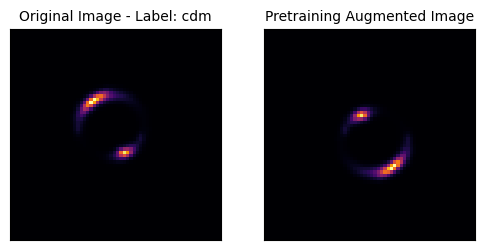

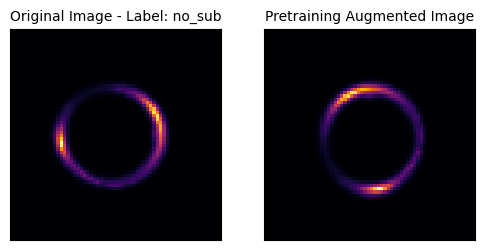

In [61]:
class DeepLensDataLoader:
    def __init__(self, data_path='Model_IV/train', val_path = 'Model_IV/val', test_size=0.2, random_state=42):
        self.classes = ['cdm', 'no_sub'] # 'axion'
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.classes)}

        file_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(data_path, class_name)
            file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]
            
        self.train_files, self.test_files = train_test_split(file_paths, test_size=test_size, random_state=random_state)
        self.steps_per_epoch = len(self.train_files) // batch_size
        self.test_steps = len(self.test_files) // batch_size
        
        val_paths = []
        for class_name_val in self.classes:
            class_dir_val = os.path.join(val_path, class_name_val)
            val_paths += [os.path.join(class_dir_val, file) for file in os.listdir(class_dir_val)]
        random.shuffle(val_paths) 
        
        self.val_files = val_paths
        self.val_steps = len(self.val_files) // batch_size
    
    def get_data(self):
        return self.steps_per_epoch, self.test_steps, self.val_steps

    def load_image(self, input_path):
        class_name = os.path.basename(os.path.dirname(input_path))
        # if class_name == 'axion':
        #     input = np.load(input_path, allow_pickle=True)[0][..., np.newaxis]
        # else:
            # input = np.load(input_path, allow_pickle=False)[..., np.newaxis]
        input = np.load(input_path, allow_pickle=False)[..., np.newaxis]
        input = np.squeeze(input)
        input = np.expand_dims(input, axis=-1)

#         img_3d = np.repeat(input, 3, axis=-1) # For RGB channel
#         img_3d  = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d)) # For RGB channel
        return input

    def pretrain_generator(self):
        while True:
            for batch_id in range(self.steps_per_epoch):
                yield self.get_batch_pretraining(batch_id)
                
    def get_batch_pretraining(self, batch_id):
        batch_paths = self.train_files[batch_id*batch_size:(batch_id+1)*batch_size]
        augmented_images_1, augmented_images_2 = [], []
        for input_path in batch_paths:
            img_3d = self.load_image(input_path)
            augmented_images_1.append(augment_image_pretraining(img_3d))
            augmented_images_2.append(augment_image_pretraining(img_3d))
        x_batch_1 = np.array(augmented_images_1)
        x_batch_2 = np.array(augmented_images_2)
        return x_batch_1, x_batch_2  # (bs, 64, 64, 1), (bs, 64, 64, 1)


    def get_batch_finetuning(self, files, batch_id):
        batch_paths = files[batch_id*batch_size:(batch_id+1)*batch_size]
        batch_images = []
        batch_output = []
        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = self.class_indices[class_name] 
            img_3d = self.load_image(input_path)
            batch_images.append(img_3d)
            batch_output.append(label)
        x_batch = np.array(batch_images)
        y_batch = to_categorical(batch_output, num_classes=2) # For one hot  # 'axion': 3
#         y_batch = np.array(batch_output) # for label
        return x_batch, y_batch  # (bs, 64, 64, 1), (bs)
        
    def train_generator(self):
        while True:
            random.shuffle(self.train_files)
            for batch_id in range(self.steps_per_epoch):
                yield self.get_batch_finetuning(self.train_files, batch_id)

    def test_generator(self):
        while True:
            for batch_id in range(self.test_steps):
                yield self.get_batch_finetuning(self.test_files, batch_id)
                
    def validation_generator(self):
        while True:
            for batch_id in range(self.val_steps):
                yield self.get_batch_finetuning(self.val_files, batch_id)

    def plot_sample_image(self, image_path):
        img_3d = self.load_image(image_path)
        class_name = os.path.basename(os.path.dirname(image_path))
        label = self.class_indices[class_name]
        # Augment the image for pretraining and finetuning
        pretraining_augmented_img = augment_image_pretraining(img_3d)
        # Plot the original, pretraining augmented, and finetuning augmented images
        fig, axs = plt.subplots(1, 2, figsize=(6, 6))
        
        axs[0].imshow(np.mean(img_3d, axis=2), cmap = 'inferno')
        axs[0].set_title('Original Image - Label: ' + class_name, fontsize = 10)
        
        axs[1].imshow(np.mean(pretraining_augmented_img, axis=2), cmap = 'inferno')
        axs[1].set_title('Pretraining Augmented Image', fontsize = 10)
        
        # Remove the x and y ticks
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        
        plt.show()
        
data = DeepLensDataLoader()
steps_per_epoch, test_steps, val_steps = data.get_data()

data_loader = DeepLensDataLoader(data_path='Model_IV/train')

# Get the first 5 image paths
first_five_images = data_loader.train_files[:2]

# Plot the images
for image_path in first_five_images:
    data_loader.plot_sample_image(image_path)

In [62]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
          layers.Dense(width*8,  activation='relu'), #256*8 = 2048
          layers.BatchNormalization(), 
          layers.Dropout(0.5),
        
          layers.Dense(width*4,  activation='relu'), #256*4 = 1024
          layers.BatchNormalization(),
          layers.Dropout(0.5),
        
          layers.Dense(width,  activation='relu'), #512
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model

In [63]:
model_supervised = tf.keras.models.Sequential([
    get_encoder(),
    tf.keras.layers.Dense(2, activation='softmax'), # 'axion': Dense(3,
])
model_supervised.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', tf.keras.metrics.AUC(name='auc')]
)
model_supervised.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 2048)              208263936 
                                                                 
 dense_19 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 208268034 (794.48 MB)
Trainable params: 208161666 (794.07 MB)
Non-trainable params: 106368 (415.50 KB)
_________________________________________________________________


In [64]:
history = model_supervised.fit(
    data.train_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_data=data.test_generator(),
    validation_steps=test_steps,
    epochs=num_epochs
)

Epoch 1/30
229/229 [==============================] - 129s 541ms/step - loss: 0.9582 - acc: 0.5020 - auc: 0.5025 - val_loss: 0.7427 - val_acc: 0.4942 - val_auc: 0.4929
Epoch 2/30
229/229 [==============================] - 119s 520ms/step - loss: 0.7688 - acc: 0.5083 - auc: 0.5111 - val_loss: 0.7457 - val_acc: 0.4930 - val_auc: 0.4948
Epoch 3/30
229/229 [==============================] - 119s 520ms/step - loss: 0.7457 - acc: 0.5173 - auc: 0.5239 - val_loss: 0.7275 - val_acc: 0.4992 - val_auc: 0.4930
Epoch 4/30
229/229 [==============================] - 119s 520ms/step - loss: 0.7408 - acc: 0.5117 - auc: 0.5178 - val_loss: 0.8902 - val_acc: 0.5040 - val_auc: 0.5013
Epoch 5/30
229/229 [==============================] - 116s 508ms/step - loss: 0.7371 - acc: 0.5183 - auc: 0.5257 - val_loss: 0.7013 - val_acc: 0.4967 - val_auc: 0.5060
Epoch 6/30
229/229 [==============================] - 116s 506ms/step - loss: 0.7416 - acc: 0.5188 - auc: 0.5263 - val_loss: 1.1187 - val_acc: 0.5088 - val_auc:

In [ ]:
model_supervised.save('supervised_resnet_baseline.h5')
with open('supervised_baseline_resnet50.pkl', 'wb') as file:
    pickle.dump(history.history, file)

#### BYOL

In [ ]:
width = 128
num_epochs = 10
batch_size = 128
lr = 1e-4
input_shape = (64, 64, 1)

data = DeepLensDataLoader()
steps_per_epoch, test_steps, val_steps = data.get_data()

In [ ]:
class ProjectionHead(tf.keras.Model):
    def __init__(self):
        super(ProjectionHead, self).__init__()
        self.fc1 = tf.keras.layers.Dense(units=64)
        self.bn = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(units=32)

    def call(self, inp, training=False):
        x = self.fc1(inp)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.fc2(x)
        return x

def byol_loss(p, z):
    """
    It calculates the mean similarity between the prediction p and the target z, 
    which are both normalized to unit length with tf.math.l2_normalize. It then returns 2 - 2 * mean_similarity, 
    which is equivalent to 2(1 - mean_similarity), so that the loss is minimized when the cosine similarity between p and z is maximized.
    """
    p = tf.math.l2_normalize(p, axis=1)  
    z = tf.math.l2_normalize(z, axis=1)  

    similarities = tf.reduce_sum(tf.multiply(p, z), axis=1)
    return 2 - 2 * tf.reduce_mean(similarities)

# Instantiate networks
f_online = get_encoder()
g_online = ProjectionHead()
q_online = ProjectionHead()

f_target = get_encoder()
g_target = ProjectionHead()


# Initialize the weights of the networks
x = tf.random.normal((batch_size, 64, 64, 1))
h = f_online(x, training=False)
print('Initializing online networks...')
print('Shape of h:', h.shape)
z = g_online(h, training=False)
print('Shape of z:', z.shape)
p = q_online(z, training=False)
print('Shape of p:', p.shape)

h = f_target(x, training=False)
print('Initializing target networks...')
print('Shape of h:', h.shape)
z = g_target(h, training=False)
print('Shape of z:', z.shape)

num_params_f = tf.reduce_sum([tf.reduce_prod(var.shape) for var in f_online.trainable_variables])    
print('The encoders have {} trainable parameters each.'.format(num_params_f))

# Define optimizer
lr = 1e-4
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
print('Using Adam optimizer with learning rate {}.'.format(lr))
    
class BYOLModel(tf.keras.Model):
    def __init__(self, f_online, g_online, q_online, f_target, g_target, beta=0.99, **kwargs):
        super().__init__(**kwargs)
        self.f_online = f_online
        self.g_online = g_online
        self.q_online = q_online
        self.f_target = f_target
        self.g_target = g_target
        self.beta = beta
        
    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
    
    def train_step(self, data):
        x1, x2 = data

        # Forward pass
        with tf.GradientTape(persistent=True) as tape:
            h_target_1 = self.f_target(x1, training=True)
            z_target_1 = self.g_target(h_target_1, training=True)

            h_target_2 = self.f_target(x2, training=True)
            z_target_2 = self.g_target(h_target_2, training=True)

            h_online_1 = self.f_online(x1, training=True)
            z_online_1 = self.g_online(h_online_1, training=True)
            p_online_1 = self.q_online(z_online_1, training=True)
            
            h_online_2 = self.f_online(x2, training=True)
            z_online_2 = self.g_online(h_online_2, training=True)
            p_online_2 = self.q_online(z_online_2, training=True)
            
            p_online = tf.concat([p_online_1, p_online_2], axis=0)
            z_target = tf.concat([z_target_2, z_target_1], axis=0)
            loss = byol_loss(p_online, z_target)

        # Calculate gradients and update online networks
        trainable_vars = self.f_online.trainable_variables + self.g_online.trainable_variables + self.q_online.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update target networks
        for online_var, target_var in zip(self.f_online.variables, self.f_target.variables):
            target_var.assign(self.beta * target_var + (1 - self.beta) * online_var)
        
        for online_var, target_var in zip(self.g_online.variables, self.g_target.variables):
            target_var.assign(self.beta * target_var + (1 - self.beta) * online_var)

        return {"loss": loss}
    
byol_model = BYOLModel(f_online, g_online, q_online, f_target, g_target)
byol_model.compile(optimizer=opt)

Initializing online networks...
Shape of h: (128, 128)
Shape of z: (128, 32)
Shape of p: (128, 32)
Initializing target networks...
Shape of h: (128, 128)
Shape of z: (128, 32)
The encoders have 26220288 trainable parameters each.
Using Adam optimizer with learning rate 0.0001.


In [13]:
# byol_model.fit(data.pretrain_generator(), epochs=num_epochs, steps_per_epoch=steps_per_epoch) 
# byol_model.load_weights('pretraining_byol.h5')

In [ ]:
byol_model.fit(data.pretrain_generator(), epochs=num_epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/10
615/615 [==============================] - 1942s 3s/step - loss: 0.8397
Epoch 2/10
615/615 [==============================] - 1997s 3s/step - loss: 0.1165
Epoch 3/10
615/615 [==============================] - 1960s 3s/step - loss: 0.0649
Epoch 4/10
615/615 [==============================] - 2023s 3s/step - loss: 0.0464
Epoch 5/10
615/615 [==============================] - 2017s 3s/step - loss: 0.0369
Epoch 6/10
615/615 [==============================] - 2044s 3s/step - loss: 0.0316
Epoch 7/10
615/615 [==============================] - 1975s 3s/step - loss: 0.0276
Epoch 8/10
615/615 [==============================] - 2042s 3s/step - loss: 0.0248
Epoch 9/10
615/615 [==============================] - 1982s 3s/step - loss: 0.0222
Epoch 10/10
615/615 [==============================] - 2031s 3s/step - loss: 0.0201


In [ ]:
byol_model.save_weights('pretraining_byol.h5')

In [ ]:
width = 128
num_epochs = 30
batch_size = 128
lr = 1e-4
input_shape = (64, 64, 1)

data = DeepLensDataLoader()
steps_per_epoch, test_steps, val_steps = data.get_data()

In [ ]:
# byol_model.load_weights('pretraining_byol.h5')
pretrained_encoder = byol_model.f_online
# Everything that creates variables should be under the strategy scope
finetuning_model = tf.keras.models.Sequential([pretrained_encoder, tf.keras.layers.Dense(2, activation='softmax')]) # 'axion': Dense(3,
finetuning_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate= 1e-4),loss=keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['acc', metrics.AUC(name='auc')])
finetuning_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128)               26276736  
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 26,277,123
Trainable params: 26,220,675
Non-trainable params: 56,448
_________________________________________________________________


In [ ]:
history_finetuning = finetuning_model.fit(
    data.train_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_data=data.test_generator(),
    validation_steps=test_steps,
    epochs=num_epochs
)

Epoch 1/30
615/615 [==============================] - 493s 790ms/step - loss: 1.3182 - acc: 0.3333 - auc: 0.5005 - val_loss: 1.1225 - val_acc: 0.3334 - val_auc: 0.5017
Epoch 2/30
615/615 [==============================] - 442s 719ms/step - loss: 1.2359 - acc: 0.3334 - auc: 0.5013 - val_loss: 1.4534 - val_acc: 0.3385 - val_auc: 0.4998
Epoch 3/30
615/615 [==============================] - 437s 711ms/step - loss: 1.2046 - acc: 0.3330 - auc: 0.5003 - val_loss: 1.1042 - val_acc: 0.3325 - val_auc: 0.5003
Epoch 4/30
615/615 [==============================] - 437s 710ms/step - loss: 1.1794 - acc: 0.3334 - auc: 0.5017 - val_loss: 1.3719 - val_acc: 0.3315 - val_auc: 0.5038
Epoch 5/30
615/615 [==============================] - 434s 706ms/step - loss: 0.8210 - acc: 0.5955 - auc: 0.8081 - val_loss: 5.2767 - val_acc: 0.3465 - val_auc: 0.5579
Epoch 6/30
615/615 [==============================] - 440s 715ms/step - loss: 0.4940 - acc: 0.8025 - auc: 0.9339 - val_loss: 9.0409 - val_acc: 0.3303 - val_auc:

In [ ]:
finetuning_model.save_weights('finetuning_byol.h5')
with open('history_finetuning.pkl', 'wb') as file:
    pickle.dump(history_finetuning.history, file)

#### Results

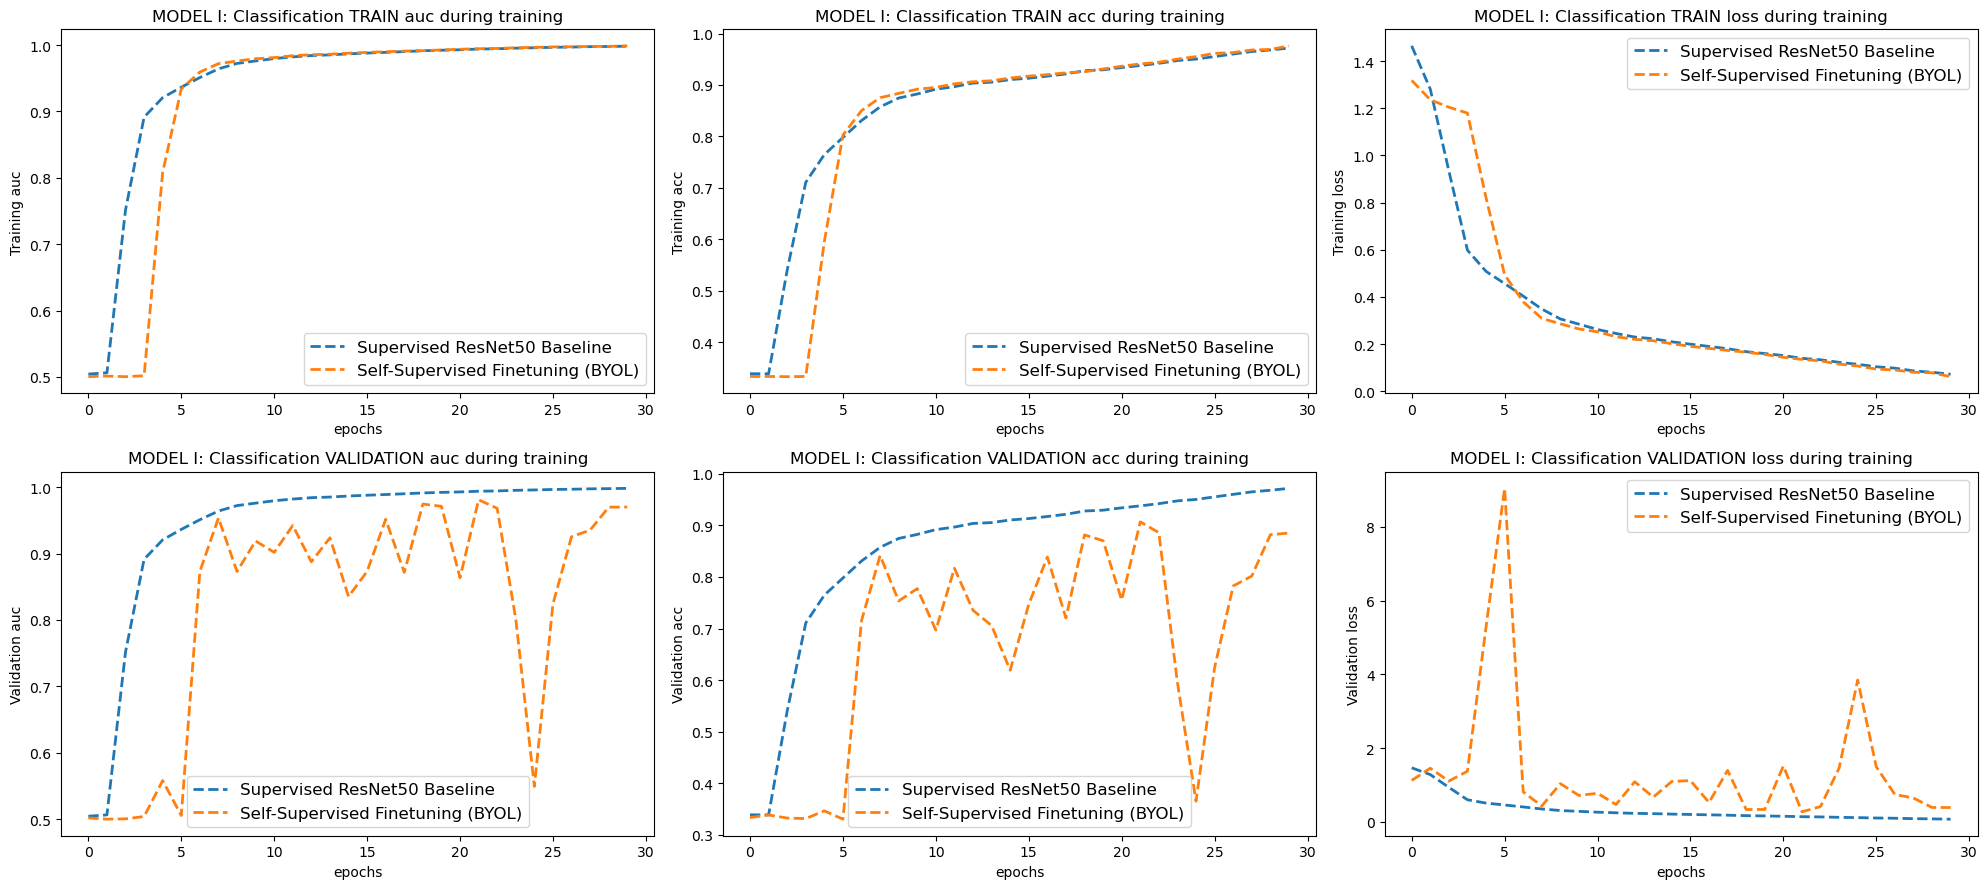

In [ ]:
def plot_training_curves(history, history_finetuning):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)
    
    metric_keys = ["auc", "acc", "loss"]
    metric_names = ["auc", "acc", "loss"]
    
    # Plotting for MODEL IV Training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(history.history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(history_finetuning.history[f"{metric_key}"], label="Self-Supervised Finetuning (BYOL)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large')
        axes[0,i].set_title(f"MODEL IV: Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for MODEL IV Validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(history.history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(history_finetuning.history[f"val_{metric_key}"], label="Self-Supervised Finetuning (BYOL)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large')
        axes[1,i].set_title(f"MODEL IV: Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history, history_finetuning)

In [ ]:
val_file_paths = []
classes = ['axion', 'cdm', 'no_sub']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}
for class_name in classes:
    val_class_dir = os.path.join('Model_IV/val' , class_name)
    val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]

In [ ]:
num_batches = val_steps

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning = []
y_pred_finetuning = []

for i in range(num_batches):
    X_batch, y_batch = next(data.validation_generator())
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(model_supervised.predict(X_batch))
    y_true_finetuning.extend(y_batch)
    y_pred_finetuning.extend(finetuning_model.predict(X_batch))
# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(data.validation_generator())
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(model_supervised.predict(X_batch))
    y_true_finetuning.extend(y_batch)
    y_pred_finetuning.extend(finetuning_model.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning = np.array(y_true_finetuning)
y_pred_finetuning = np.array(y_pred_finetuning)

In [ ]:
y_true_baseline_int = np.argmax(y_true_baseline, axis=1)
y_pred_baseline_int = np.argmax(y_pred_baseline, axis=1)
y_true_finetuning_int = np.argmax(y_true_finetuning, axis=1)
y_pred_finetuning_int = np.argmax(y_pred_finetuning, axis=1)

auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
print("Separate test set results (MODEL IV test: Containing 5000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")  
accuracy_baseline = accuracy_score(y_true_baseline_int, y_pred_baseline_int)
print("\nMODEL IV: Classification Report (Baseline):")
print(classification_report(y_true_baseline_int, y_pred_baseline_int))

auc_finetuning = roc_auc_score(y_true_finetuning, y_pred_finetuning, average='macro', multi_class='ovr')
print("Separate test set results (MODEL IV test: Containing 5000 samples per class):\n")
print(f"AUC (Finetuning): {int(auc_finetuning * 1000) / 1000}")  
accuracy_finetuning = accuracy_score(y_true_finetuning_int, y_pred_finetuning_int)
print("\nMODEL IV: Classification Report (Finetuning):")
print(classification_report(y_true_finetuning_int, y_pred_finetuning_int))

In [ ]:
# Assuming these are your data variables
datasets = {
    "Resnet50 Baseline": (y_true_baseline, y_pred_baseline),
    "Finetuned BYOL": (y_true_finetuning, y_pred_finetuning),
}

plt.figure(figsize=(12, 8), dpi=100) 
for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.subplot(len(datasets), 2, 2*idx+1)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'MODEL IV: Confusion Matrix \n({title})', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=11)
    plt.ylabel('True Labels', fontsize=11)

    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, class_indices)
    plt.yticks(tick_marks, class_indices, rotation=90)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.subplot(len(datasets), 2, 2*idx+2)
    for class_name, i in class_indices.items():
        plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'MODEL IV: ROC \n({title})', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
